# Logical shadow tomography: Convergence in number of samples

## Setup

In [62]:
from io import StringIO
from joblib import Parallel, delayed
from typing import Iterable, List
import urllib.request

import matplotlib.pyplot as plt
import numpy as np

from base.stabilizer import random_clifford_state, stabilizer_state, stoc_depolarize_map
from base.utils import stabilizer_projection_full

In [63]:
plt.rcParams.update({"font.family": "serif", "font.size": 14})

## Helper functions

In [64]:
def symplectic_to_string(symplectic_pauli: Iterable[int]) -> str:
    assert len(symplectic_pauli) % 2 == 0
    n = len(symplectic_pauli) // 2
    xs = symplectic_pauli[:n]
    zs = symplectic_pauli[n:]
    
    phase_exponent: int = 0
    pauli: str = ""
    for (x, z) in zip(xs, zs):
        if x and z:
            pauli += "Y"
            phase_exponent += 1
        elif x and not z:
            pauli += "X"
        elif not x and z:
            pauli += "Z"
        elif not x and not z:
            pauli += "I"
        else:
            raise Exception(f"x = {x}, z = {z}.")
    
    if phase_exponent % 4 == 0:
        phase = ""
    elif phase_exponent % 2 == 0:
        phase = "-"
    else:
        raise Exception(f"phase_exponent = {phase_exponent}.")
    return phase + pauli


def check_matrix_to_stabilizers(check_matrix: Iterable[Iterable[int]]) -> List[str]:
    return [symplectic_to_string(row) for row in check_matrix]

In [65]:
"""Tests."""
assert symplectic_to_string([1, 0]) == "X"
assert symplectic_to_string([0, 1]) == "Z"

assert symplectic_to_string([1, 0, 0, 0]) == "XI"
assert symplectic_to_string([0, 1, 0, 0]) == "IX"
assert symplectic_to_string([0, 0, 1, 0]) == "ZI"
assert symplectic_to_string([0, 0, 0, 1]) == "IZ"
assert symplectic_to_string([1, 1, 0, 0]) == "XX"
assert symplectic_to_string([0, 0, 1, 1]) == "ZZ"
assert symplectic_to_string([1, 0, 0, 1]) == "XZ"
assert symplectic_to_string([0, 1, 1, 0]) == "ZX"
assert symplectic_to_string([1, 1, 1, 1]) == "-YY"

## Codes

In [5]:
# Codes from http://www.codetables.de/.
# TODO: Generate random codes for any n instead of hardcoding.
code_data_n20 = """1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 0
0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0
0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0
0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0
0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0
0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0
0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0
0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0
0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0"""
check_matrix_n20 = np.genfromtxt(StringIO(code_data_n20), delimiter=" ")


code_data_n25 = """1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0
0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0
0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0
0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0
0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0
0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0
0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0
0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0
0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1"""
check_matrix_n25 = np.genfromtxt(StringIO(code_data_n25), delimiter=" ")

code_data_n30 = """1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0
0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 0
0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0
0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0
0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0
0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0
0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0
0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0
0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0
0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0
0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0
0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0
0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1 1 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0"""
check_matrix_n30 = np.genfromtxt(StringIO(code_data_n30), delimiter=" ")


code_data_n40 = """1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0"""
check_matrix_n40 = np.genfromtxt(StringIO(code_data_n40), delimiter=" ")

In [13]:
code_data_n50 = """1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0
0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0
0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 0 0
0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0
0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0
0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0
0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0
0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0"""
check_matrix_n50 = np.genfromtxt(StringIO(code_data_n50), delimiter=" ")

In [36]:
N = 60

In [37]:


fp = urllib.request.urlopen(f"http://www.codetables.de/QECC.php?q=4&n={N}&k=1")
mybytes = fp.read()

mystr = mybytes.decode("utf8")
fp.close()

In [38]:
lines = mystr.splitlines()

In [39]:
_KEY = "    stabilizer matrix:"

In [44]:
start = lines.index(_KEY) + 2
end = start + N - 1

In [54]:
check_matrix_data = [
    line.strip().lstrip("[").rstrip("]").replace("|", " ")
    for line in lines[start: end]
]

In [59]:
check_matrix = np.genfromtxt(StringIO("\n".join(check_matrix_data)), delimiter=" ")

In [ ]:
check_matrix_lines = []

In [66]:
def get_code_from_codetables(nqubits: int) -> List[str]:
    """Returns stabilizers for an [[nqubits, 1]] code by pa"""
    fp = urllib.request.urlopen(f"http://www.codetables.de/QECC.php?q=4&n={nqubits}&k=1")
    mybytes = fp.read()
    mystr = mybytes.decode("utf8")
    fp.close()
    
    lines = mystr.splitlines()
    _KEY = "    stabilizer matrix:"
    
    start = lines.index(_KEY) + 2
    end = start + nqubits - 1
    
    check_matrix_data = [
        line.strip().lstrip("[").rstrip("]").replace("|", " ")
        for line in lines[start: end]
    ]
    check_matrix = np.genfromtxt(StringIO("\n".join(check_matrix_data)), delimiter=" ")
    return check_matrix_to_stabilizers(check_matrix)

In [72]:
get_code_from_codetables(100)

['XIIIIIIIIIIIIIIIIZZZZZZIZIIZIZIZZZZZZZIZIIZZZZIZIIIZZIIZIIZZIZZZZIZIZZIIZZZYYYYIZZIZXXIXIIIIIIIIIIII',
 'IXIIIIIIIIIIIIIIIIZZZZZZIZIIZIZIZZZZZZZIZIIZZZZIZIIIZZIIZIIZZIZZZZIZIZZIIZZZYYYYIZZIZXXIXIIIIIIIIIII',
 'IIXIIIIIIIIIIIIIIIIZZZZZZIZIIZIZIZZZZZZZIZIIZZZZIZIIIZZIIZIIZZIZZZZIZIZZIIZZZYYYYIZZIZXXIXIIIIIIIIII',
 'IIIXIIIIIIIIIIIIIIIIZZZZZZIZIIZIZIZZZZZZZIZIIZZZZIZIIIZZIIZIIZZIZZZZIZIZZIIZZZYYYYIZZIZXXIXIIIIIIIII',
 '-IIIIXIIIIIIIIIIIIZZZZIIZIZZZZZIIZIZIIIZIZZZIZZZIZZIIZIIIZIZIIZIIZZIZIZZIIIZYXXXYXXYZYYIYXXIIIIIIIIII',
 '-IIIIIXIIIIIIIIIIIIZZZZIIZIZZZZZIIZIZIIIZIZZZIZZZIZZIIZIIIZIZIIZIIZZIZIZZIIIZYXXXYXXYZYYIYXXIIIIIIIII',
 '-IIIIIIXIIIIIIIIIIZZIIIIIZZIIZIZIZZIZIZIZZIIIIZZIZIZIZIZZIIIZZZZIZIIZZIIZIZZYXIZXYXXYZYYZIYXIIIIIIIII',
 '-IIIIIIIXIIIIIIIIIZIIZZZIZZZZIIIIZIIZIZZZZZZZZZZIIZIIZZIIZIZZZIIIZZZIIIIIIZIXIZYZYXXYZYYZZIYIIIIIIIII',
 '-IIIIIIIIXIIIIIIZZZIIIZIZIZZIIZZIIIIIIZZZZIIZZZZZZIZZIZZIZIZZZZZIZIIIIZIZIIIYIYXYIYYXZXYIZIIIIIIIIIII',
 '-IIIIIIIIIXIIIIIIZZZIIIZIZIZZIIZZIIIIIIZZZZIIZZZ

In [14]:
"""Dictionary of available codes."""
codes = {
    5: ["ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ"],
    10: [
        "XZIZIXIZZI",
        "-IYIZZYIIZZ",
        "-IIYZZYIXII",
        "-IZZYIYZIIZ",
        "-IZIIXYZYII",
        "IZZIZZXXZZ",
        "IIZZZZZIXZ",
        "IZZZZIIZZX",
        "ZZZZZZIIII",
    ],
    15: [
        "XZIZIXIZZIIIIII",
        "-IYIZZYIIZZIIIII",
        "IZXIZXIIIZZIIII",
        "-IZZYIYZIIZIIIII",
        "IIZZXXZZIZZIIII",
        "-IIZZIIYZZIYIIII",
        "-IZIZZZZYIZYIIII",
        "IIIZIZIZXZXIIII",
        "IZIZIIZIZXXIIII",
        "IIIIIIIIIIIXIII",
        "IIIIIIIIIIIIXII",
        "IIIIIIIIIIIIIXI",
        "IIIIIIIIIIIIIIX",
        "ZZZZZZIIIIIIIII",
    ],
    20: check_matrix_to_stabilizers(check_matrix_n20),
#     25: check_matrix_to_stabilizers(check_matrix_n25),  # TODO: Figure out phase issue.
    30: check_matrix_to_stabilizers(check_matrix_n30),
    40: check_matrix_to_stabilizers(check_matrix_n40),
#     50: check_matrix_to_stabilizers(check_matrix_n50),  # TODO: Figure out phase issue.
}

Exception: phase_exponent = 1.

## Experiment

In [7]:
"""Set experimental parameters."""
nmin: int = 5  # Minimum number of physical qubits to use in code.
nmax: int = 20  # Maximum number of physical qubits to use in code.
step: int = 5  # Step between qubit values.

max_num_trajectories: int = 100_000  # Maximum number of trajectories to sample from.

p: float = 0.01  # Depolarizing noise rate.

njobs: int = 2  # Number of parallel workers to use when sampling trajectories.

In [8]:
# nvalues = np.arange(nmin, nmax + step, step)
nvalues = list(codes.keys())

In [9]:
def sample_trajectory(p: float):
    # Initial stabilizer state.
    state = stabilizer_state(*stabilizers)
    gs0 = state.gs.copy()
    ps0 = state.ps.copy()

    # Apply single-qubit depolarizing noise.
    state = stoc_depolarize_map(state, p)

    # Do shadow tomography.
    obs = random_clifford_state(N)
    state.measure(obs)

    gs, ps, _, tmp_PsigmaP = stabilizer_projection_full(
        state.gs, state.ps, gs0[: N - 1].copy(), ps0[: N - 1].copy(), 0
    )
    _, _, _, tmp = stabilizer_projection_full(gs, ps, gs0[:N], ps0[:N], 0)

    return tmp_PsigmaP * tmp, tmp_PsigmaP

In [10]:
"""Run the experiment."""
all_n_values = []
for N in nvalues:
    print(f"Status: On n = {N}", end="\r")

    try:
        stabilizers = codes.get(N)
    except KeyError:
        raise ValueError(
            f"Unsupported value for `N`. I only know codes for these N values: {list(codes.keys())}."
        )

    all_values = Parallel(n_jobs=njobs)(
        delayed(sample_trajectory)(p) for _ in range(max_num_trajectories)
    )
    all_n_values.append(all_values)

In [11]:
nsamples_values = np.linspace(100, max_num_trajectories, 200, dtype=int)

all_fidelities = []
for (n, all_values) in zip(nvalues, all_n_values):
    fidelities = []
    for nsamples in nsamples_values:
        num, denom = np.sum(all_values[:nsamples], axis=0)
        fid = ((2 ** n + 1) * (num / nsamples) - 1) / (
            (denom / nsamples) * (2 ** n + 1) - 2
        )
        fidelities.append(fid)
    all_fidelities.append(fidelities)

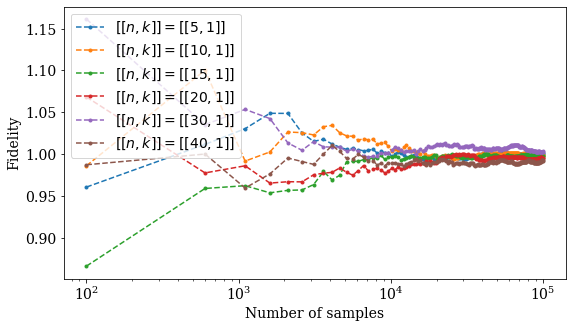

In [12]:
plt.figure(figsize=(9, 5))

for N, fids in zip(nvalues, all_fidelities):
    plt.plot(nsamples_values, fids, "--.", label=f"$[[n, k]] = [[{N}, 1]]$")

plt.xlabel("Number of samples")
plt.ylabel("Fidelity")
plt.xscale("log")
plt.legend();